# Determine Jacobinas(DelI for Del TMP) Analytically and Plot Them



In [17]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2
from tfo_sensitivity.data import load_raw
from tfo_sensitivity.jacobian import *
import seaborn as sns

# Plot Setup
plt.style.use('seaborn')

# Load Sim Data
maternal_wall_thickness, uterus_thickness, wave_int = 12, 5, 2
raw_sim_data_path = load_raw(maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100
all_sdd = raw_sim_data['SDD'].unique()

In [18]:
# Preparing the mu_a equations used for Jacobians
maternal_blood_volume_fraction = 0.2
fetal_blood_volume_fraction = 0.22

# Use 1 of theses 2 equations
# mu_a_eqn = PartialBloodJacobianMuAEqn(maternal_blood_volume_fraction, fetal_blood_volume_fraction)
mu_a_eqn = FullBloodJacobianMuAEqn()
jacobian_calculator_params =  {
    
    
    
    
    
}




In [19]:
# Plotting parameters
# plt.rcParams['figure.dpi'] = 150    # Smaller plot
plt.rcParams['figure.dpi'] = 700    # Paper-ready plots

# Values Ranges Used in Simulation
Variable | Range(lower) | Range(Upper) | Point Count
----------|--------------|-------------|--------------
Materna Sturation | 0.9 | 1.0 | 5   
Maternal Hb Conc |  11 | 15| 5   
Fetal Saturation| 0.2| 0.6| 5  
Fetal Hb Conc | 11 | 15| 5  
Maternal BVF| 0.2| |    
Fetal BVF| 0.22| |   

## Jacobian For saturation
From my derivations,
$$
\frac{\delta I}{\delta S} = -(\epsilon_{Hbo} - \epsilon_{HHb}) \times c \times \sum (L_i I_i)
$$

In [20]:
MATERNAL_Hb = 11.0
MATERNAL_SAT = 1.0
FETAL_SAT = 0.60
FETAL_Hb = 0.1  


# MATERNAL_Hb = 11.0
# MATERNAL_SAT = 1.0
# FETAL_SAT = 0.60
# FETAL_Hb = 11.0

DELTA_S = 0.001
DELTA_C = 0.01

data_table = pd.DataFrame(columns=["Saturation", "Derivative", "SDD", "Type"])
all_fetal_sat = np.arange(0.1, 0.65, 0.5)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fs in all_fetal_sat:
        fs = round(fs, 2)  # np.arange sometimes creates weird numbers... round to 2 decimal places
        dI = JC(
            raw_sim_data,
            sdd_index,
            base_mu_map,
            DELTA_S,
            "FS",
            all_sdd,
            MATERNAL_Hb,
            MATERNAL_SAT,
            FETAL_Hb,
            fs,
            wave_int,
            mu_a_eqn,
        ).calculate_jacobian()

        # Adding to Table
        new_row1 = {"Saturation": fs, "Derivative": dI, "SDD": all_sdd[sdd_index], "Type": "Numerical"}
        data_table.loc[len(data_table)] = new_row1

/tmp/ipykernel_231666/733789300.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


Text(0, 0.5, '$\\frac{\\partial I}{\\partial S_f} $')

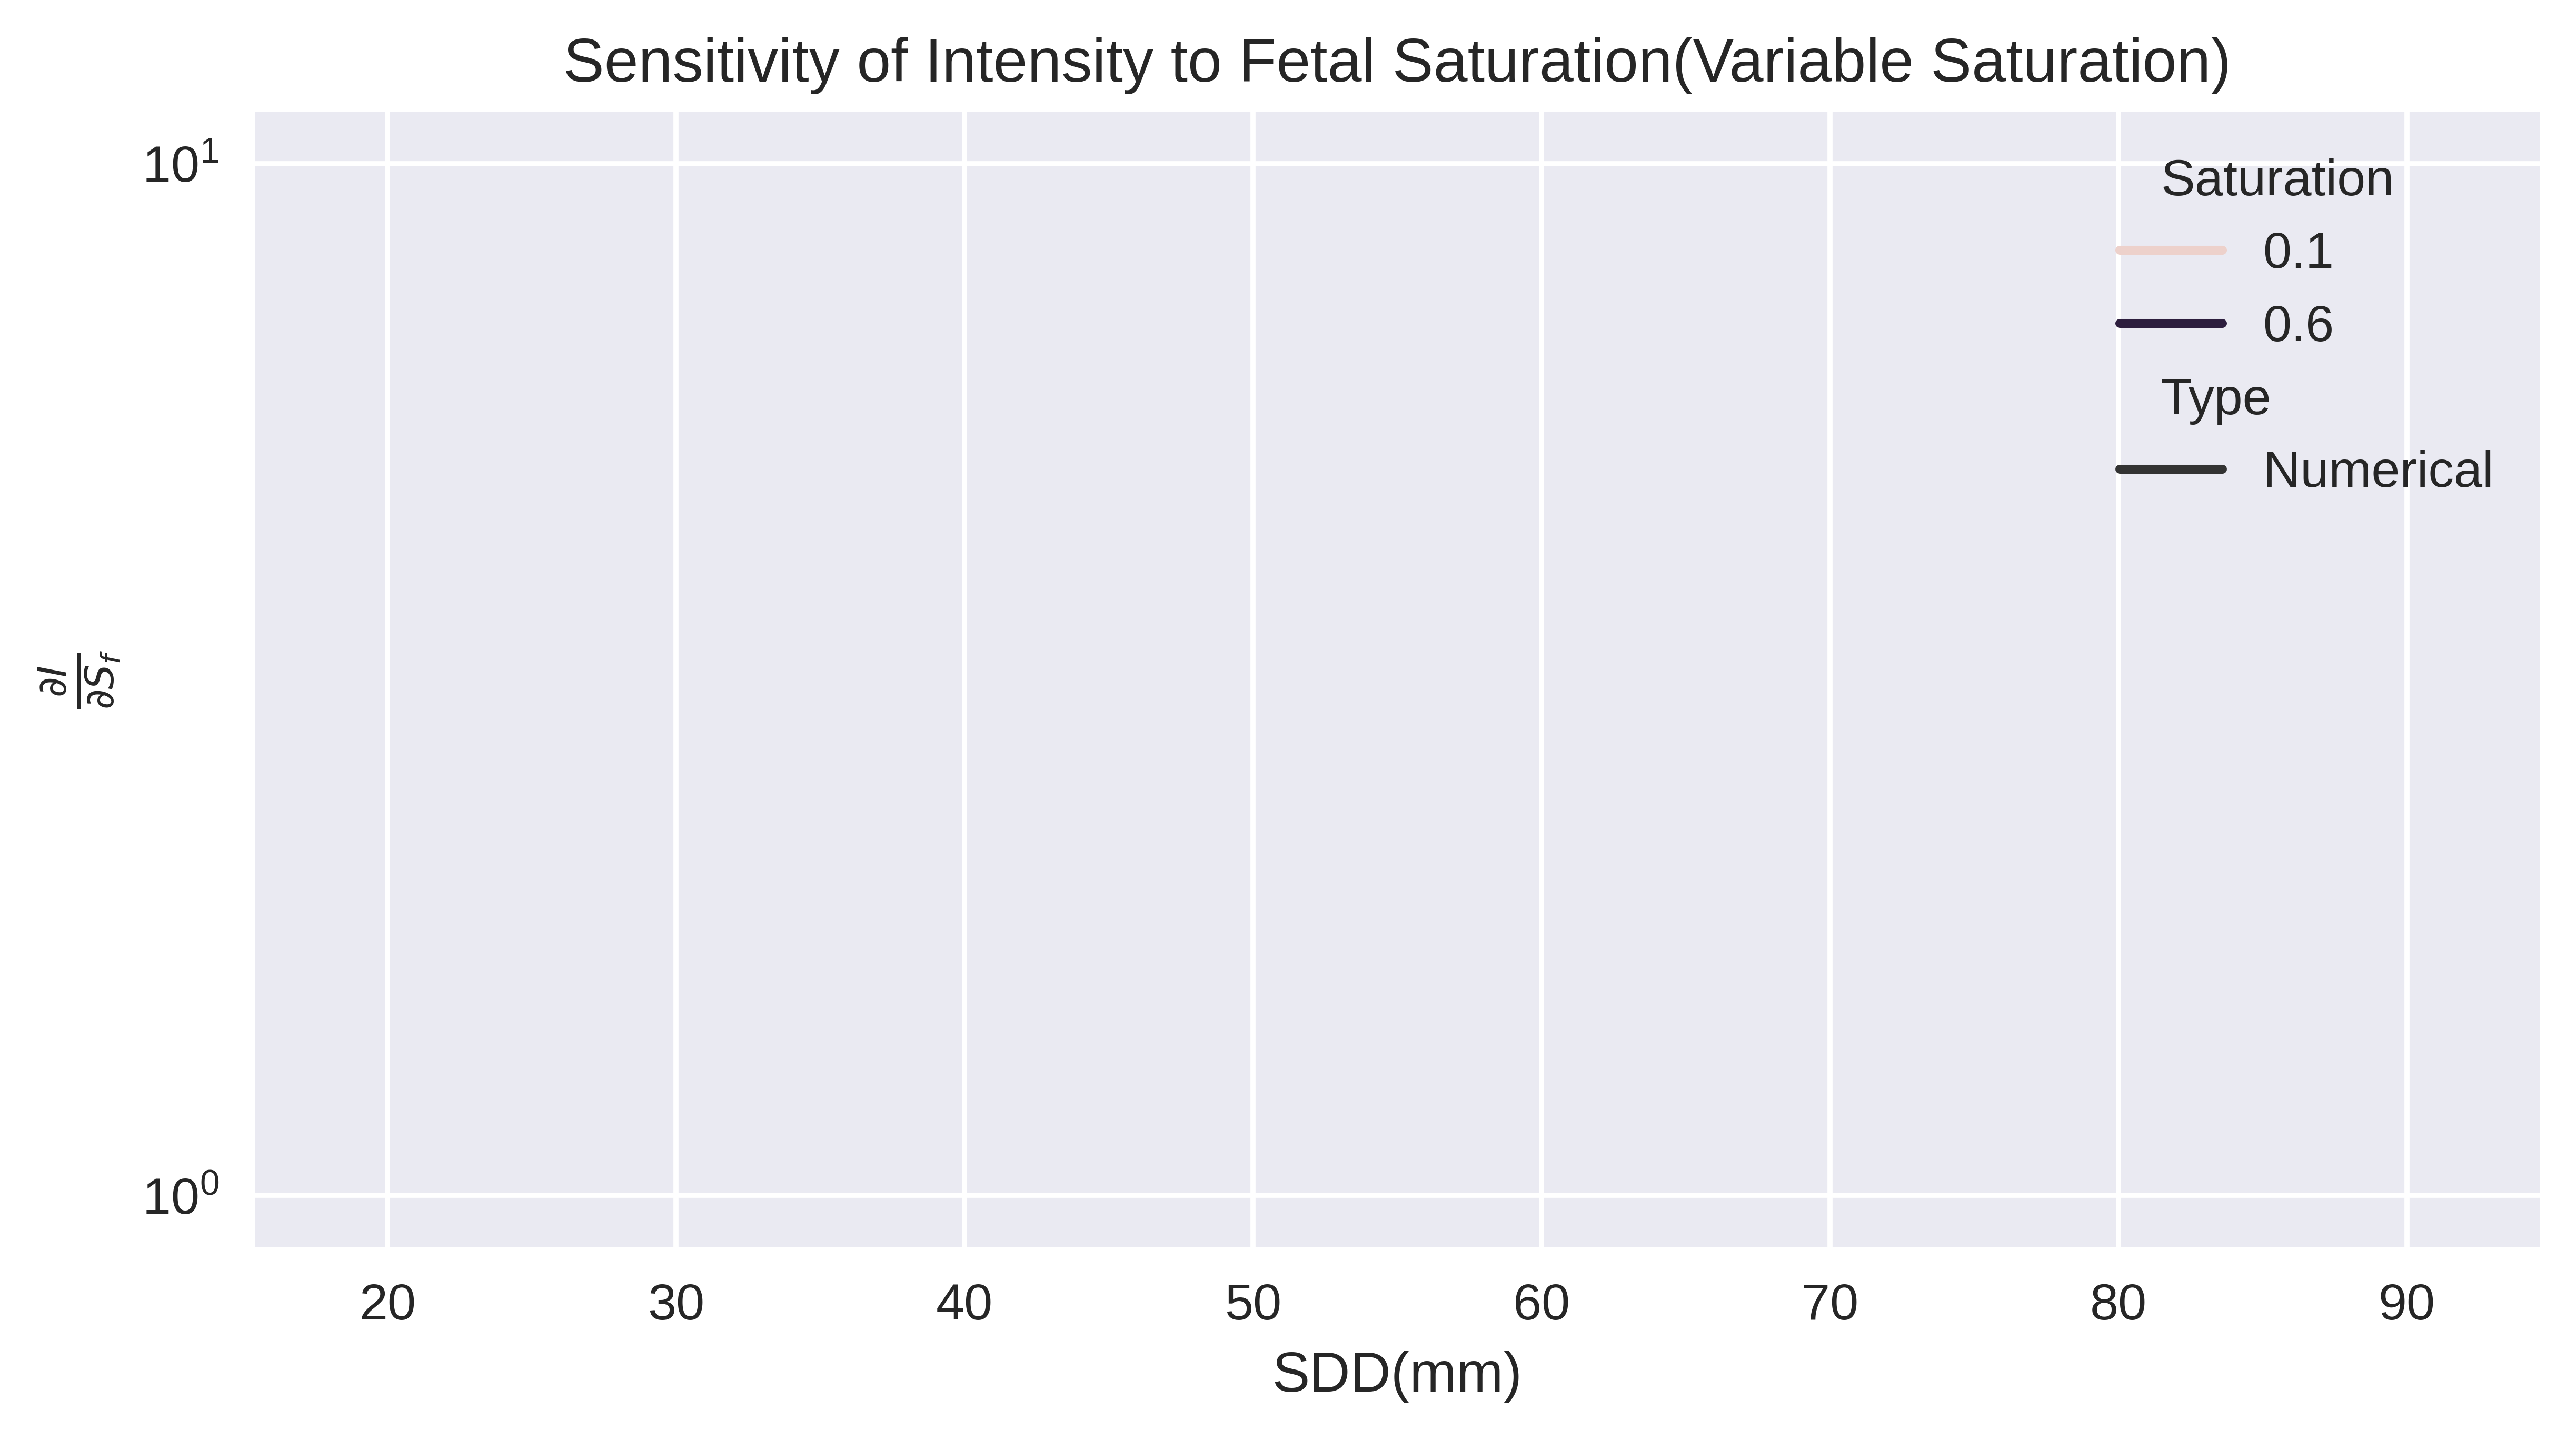

In [21]:
plt.figure(figsize=(8, 4))
data_table["Derivative"] = np.abs(data_table["Derivative"])
plot = sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Saturation', style='Type', marker='o')
plt.title('Sensitivity of Intensity to Fetal Saturation(Variable Saturation)')
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial S_f} $')

__Remarks__ : This plot is done for a constant c. The partial derivative of the first term(The $\frac{\partial log(|A(c)|)}{\partial c}$) does not have any term related to SDD. According to that part, the derivative is constant. But clearly, the derivative is not. So this would be the effect of the second term. 

In [22]:
data_table = pd.DataFrame(columns=["Concentration (g/dL)", "Derivative", "SDD", "Type"])
all_fetal_c = np.arange(11.0, 16.1, 1.0)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fc in all_fetal_c:
        dI = JC(
            raw_sim_data,
            sdd_index,
            base_mu_map,
            DELTA_S,
            "FS",
            all_sdd,
            MATERNAL_Hb,
            MATERNAL_SAT,
            fc,
            FETAL_SAT,
            wave_int,
            mu_a_eqn,
        ).calculate_jacobian()
        # Adding to Table
        new_row1 = {"Concentration (g/dL)": fc, "Derivative": dI, "SDD": all_sdd[sdd_index], "Type": "Numerical"}
        data_table.loc[len(data_table)] = new_row1

/tmp/ipykernel_231666/1355235458.py:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


Text(0, 0.5, '$\\frac{\\partial I}{\\partial S_f} $')

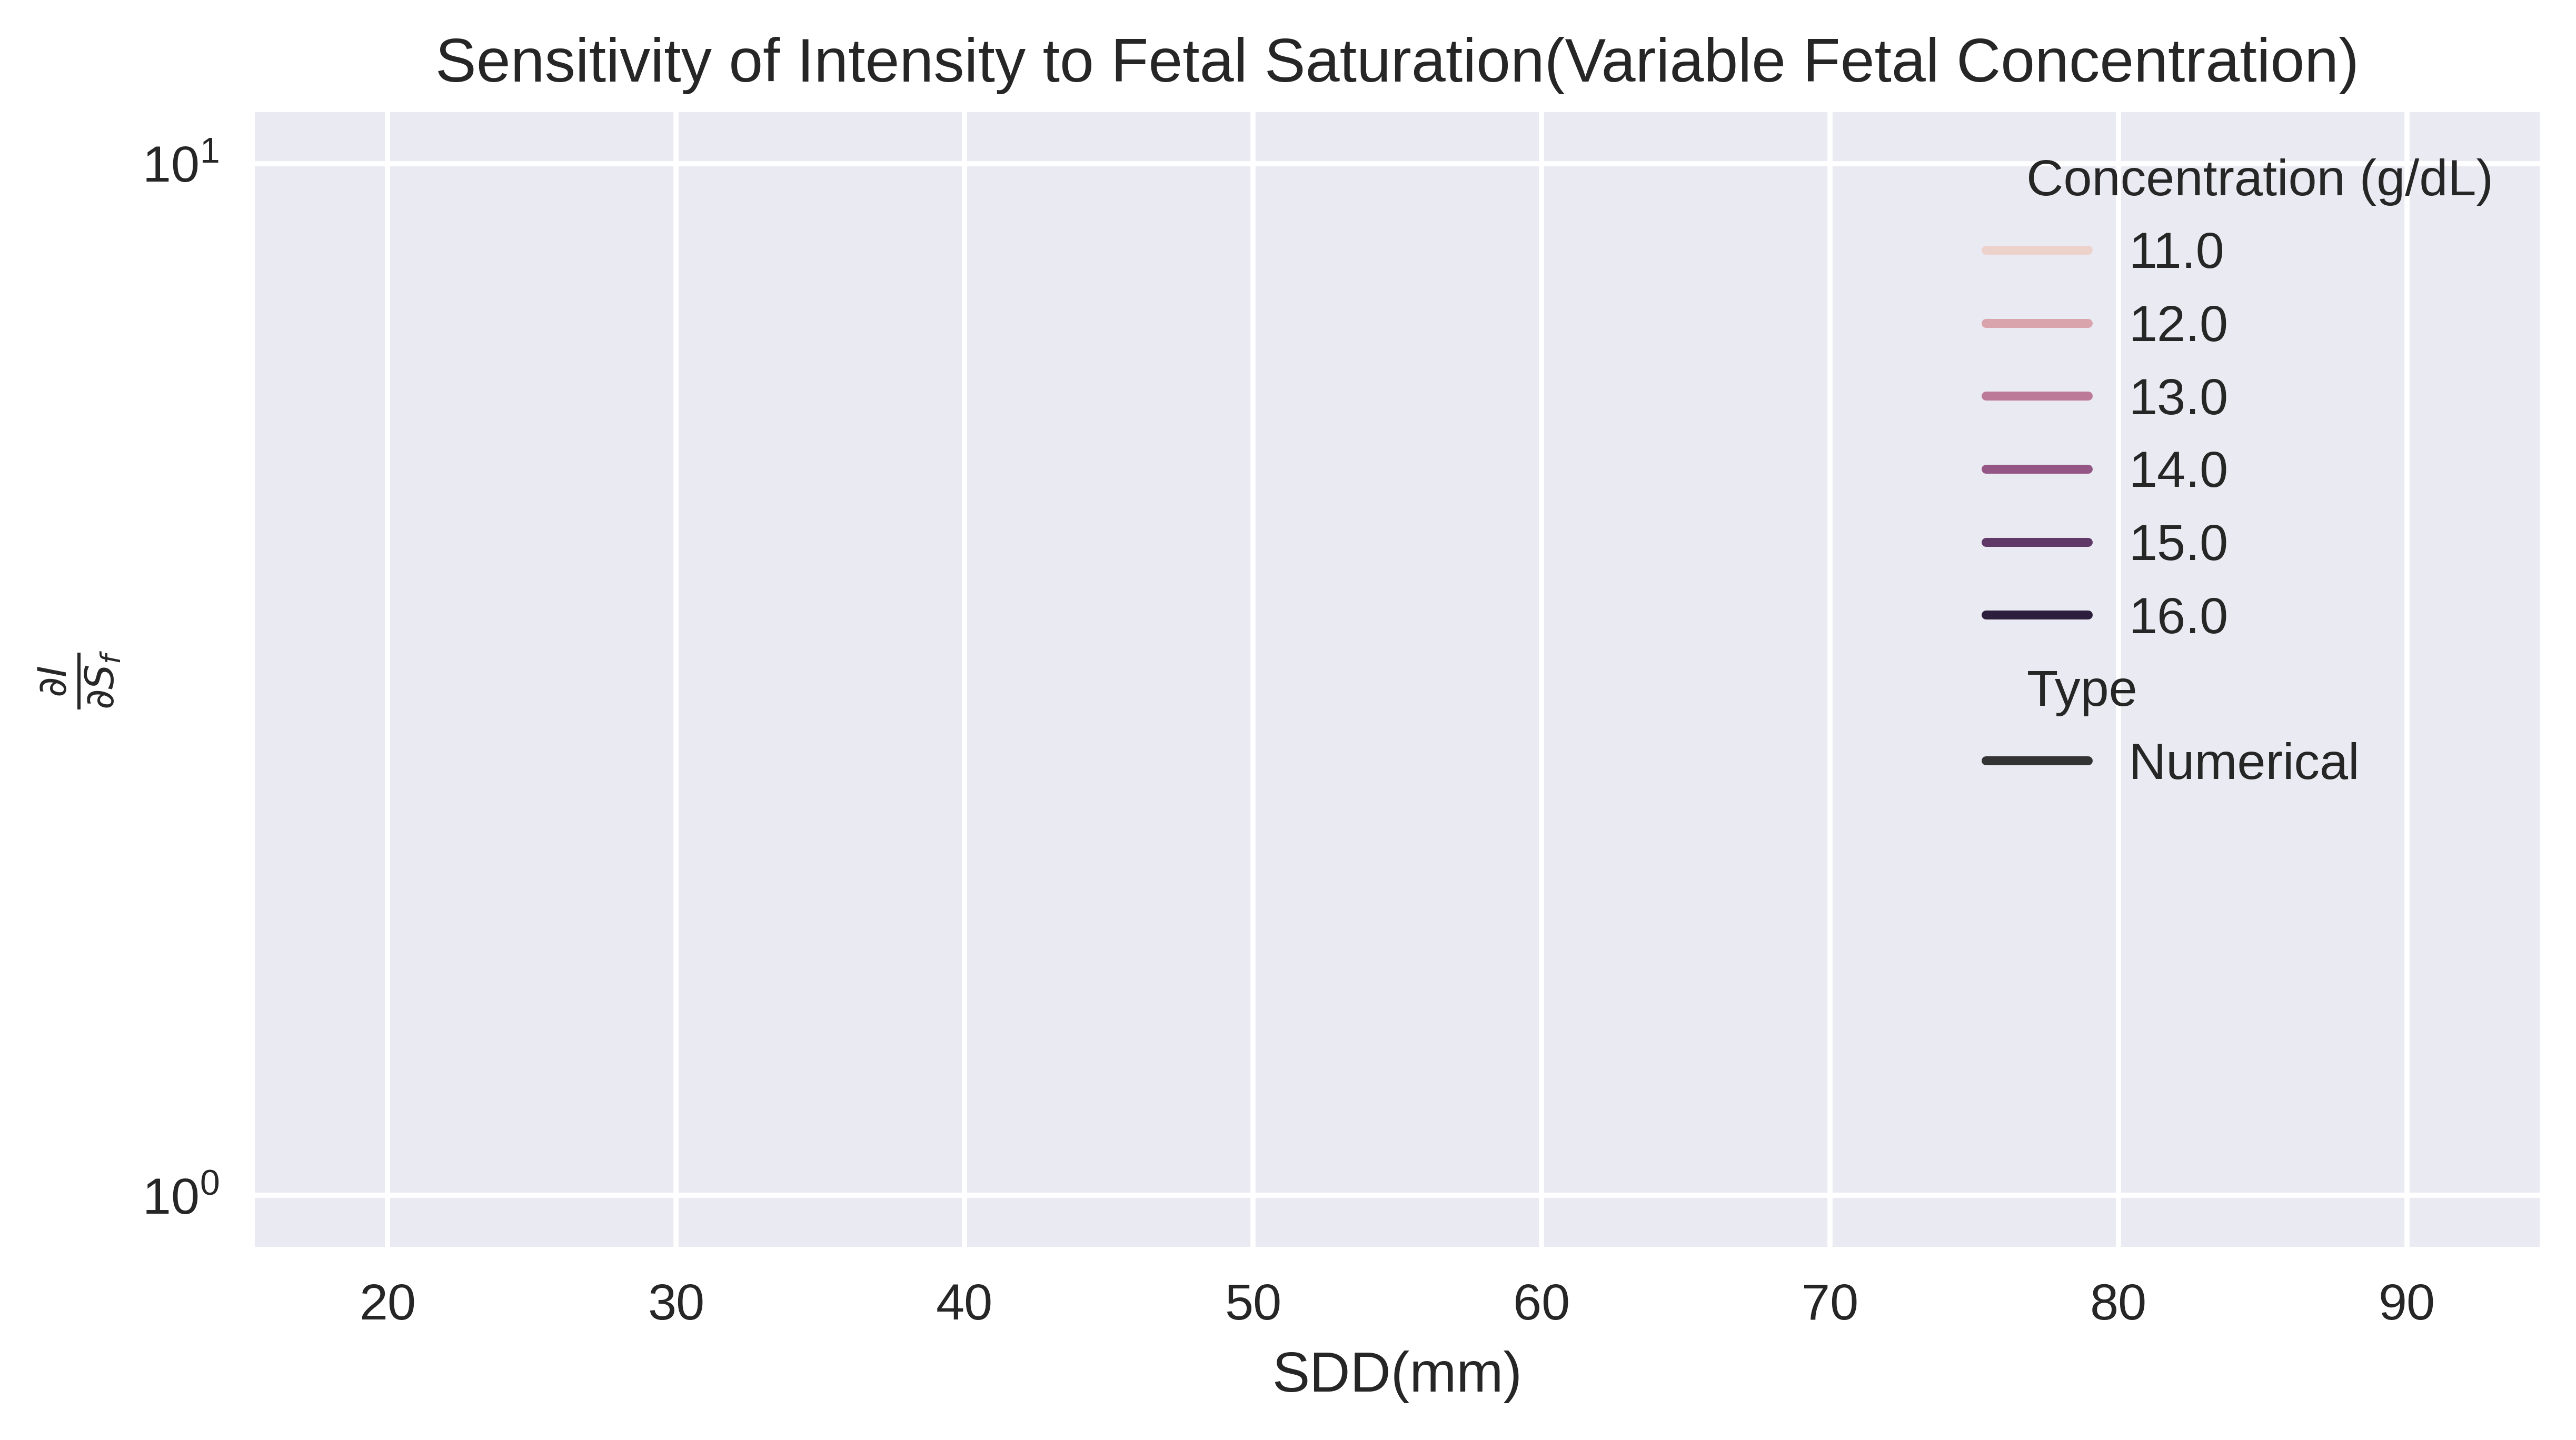

In [23]:
plt.figure(figsize=(8, 4))
data_table["Derivative"] = np.abs(data_table["Derivative"])
plot = sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Concentration (g/dL)', style='Type', marker='o')
plt.title('Sensitivity of Intensity to Fetal Saturation(Variable Fetal Concentration)')
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial S_f} $')

## Jacobian For Concentration
From my derivations,
$$
\frac{\delta I}{\delta c} = -\epsilon \times \sum (L_i I_i)
$$

In [24]:
data_table = pd.DataFrame(columns=["Concentration(g/dL)", "Derivative", "SDD", "Type"])
all_fetal_conc = np.arange(11.0, 16.1, 1.0)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2


for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fc in all_fetal_conc:
        dI = JC(
            raw_sim_data,
            sdd_index,
            base_mu_map,
            DELTA_C,
            "FC",
            all_sdd,
            MATERNAL_Hb,
            MATERNAL_SAT,
            fc,
            FETAL_SAT,
            wave_int,
        ).calculate_jacobian()
        new_row1 = {"Concentration(g/dL)": fc, "Derivative": dI, "SDD": all_sdd[sdd_index], "Type": "Numerical"}
        data_table.loc[len(data_table)] = new_row1

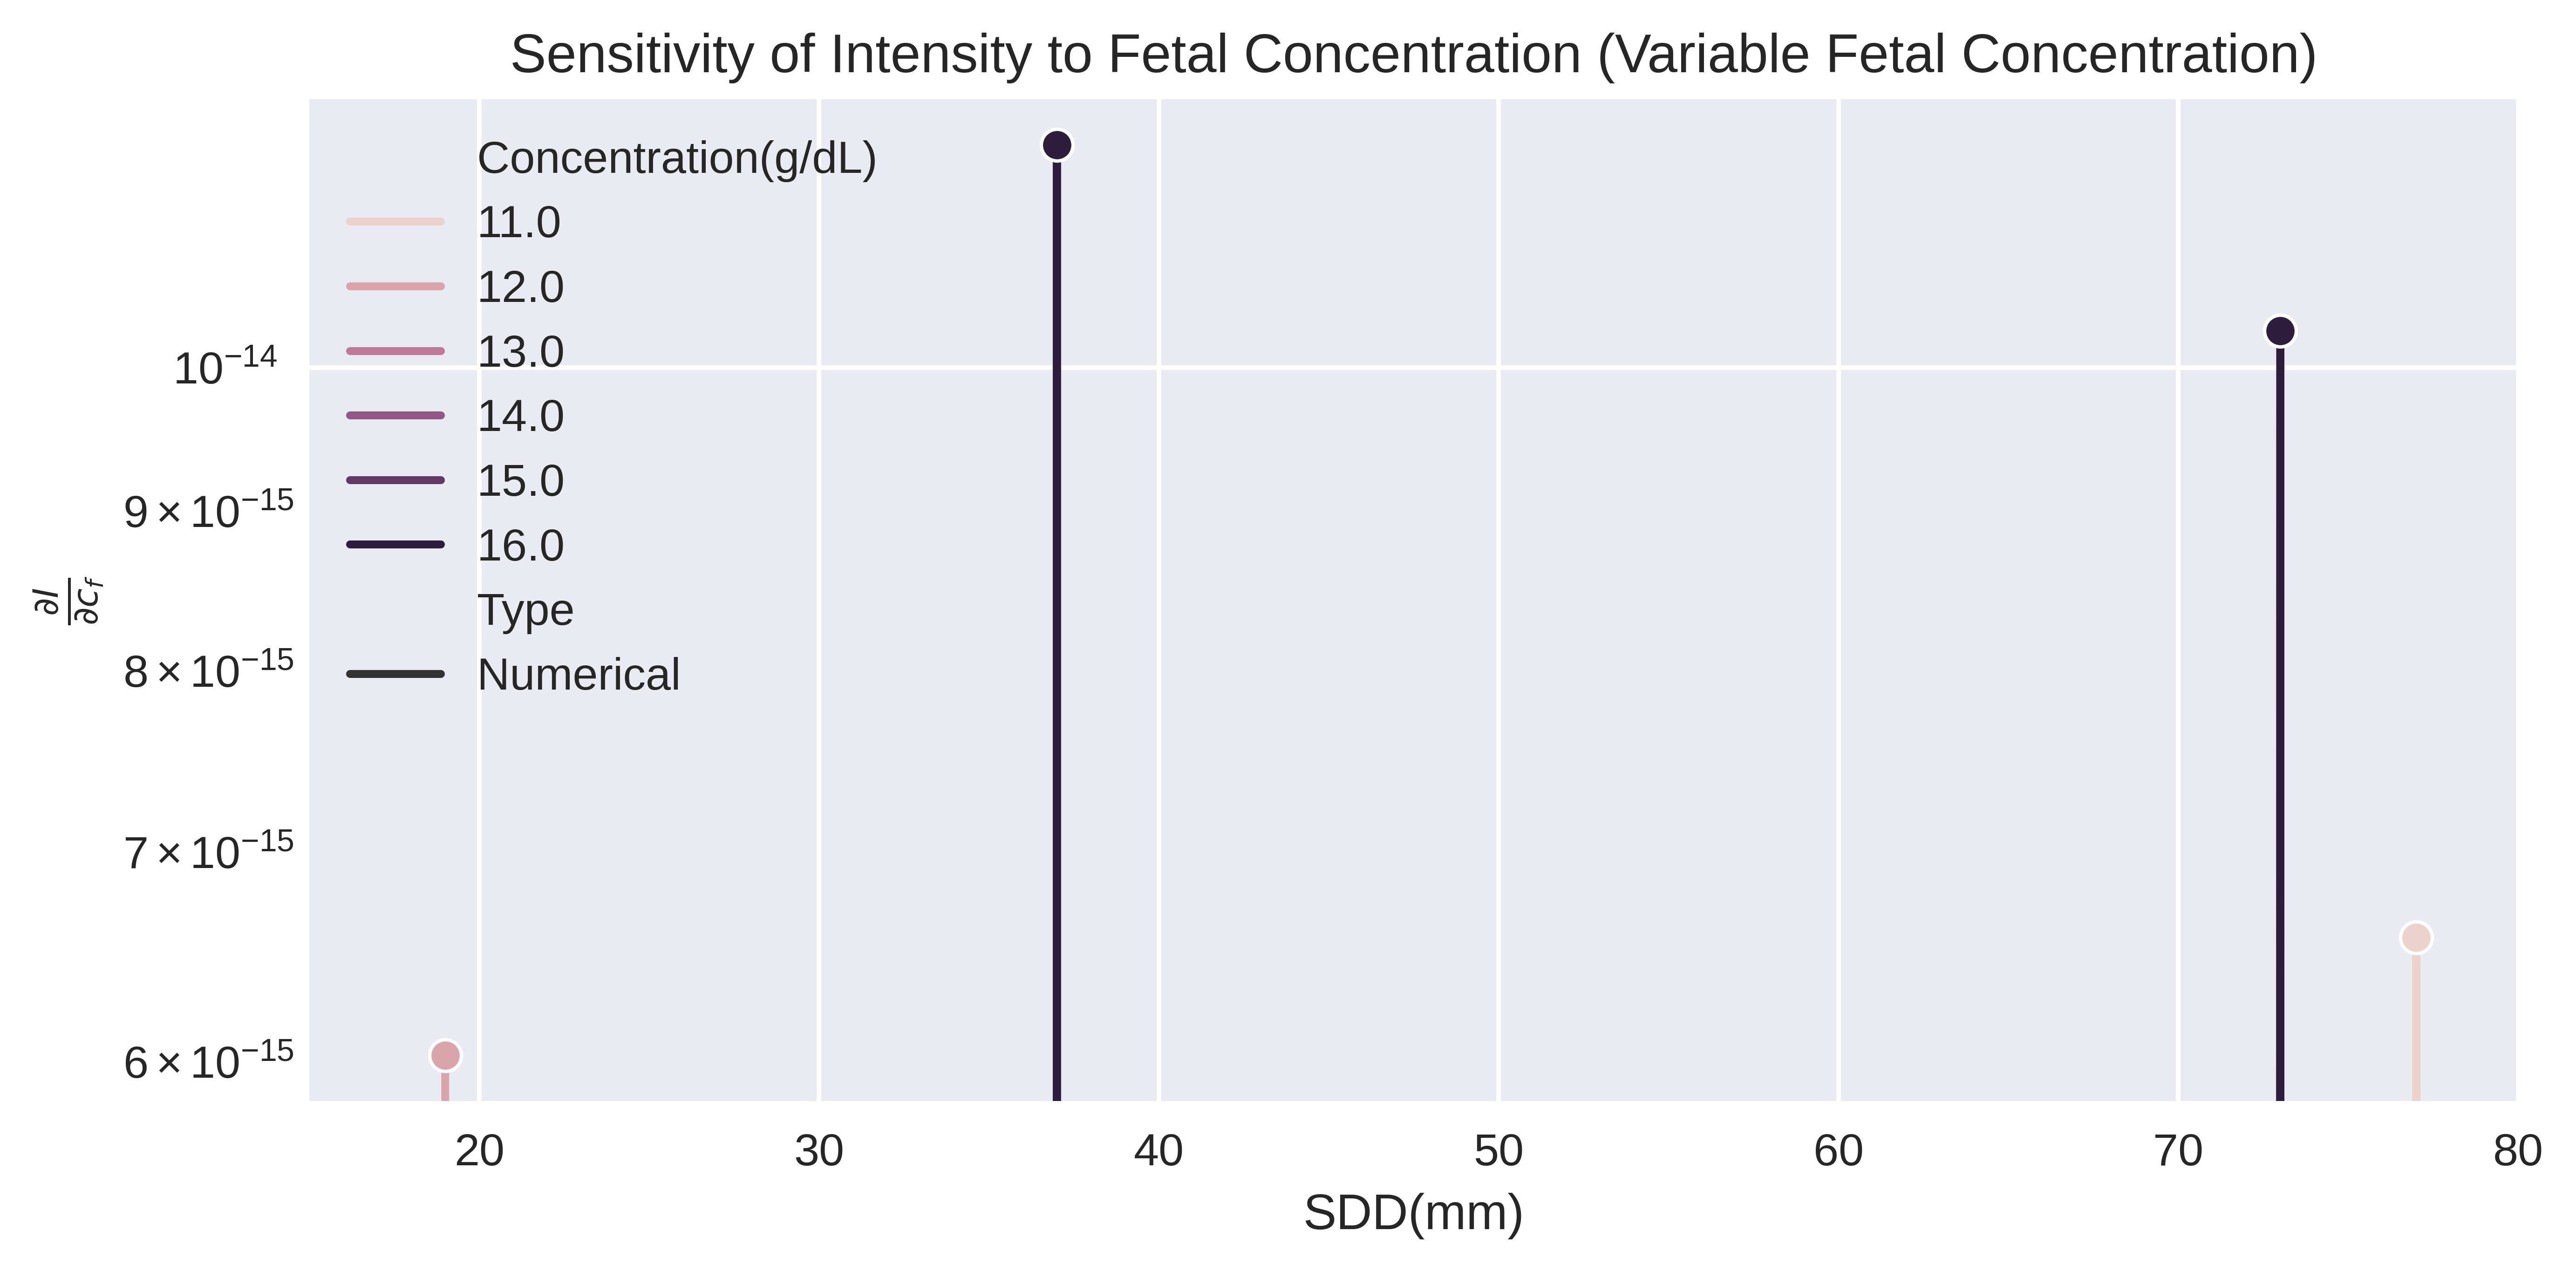

In [25]:
plt.figure(figsize=(8, 4))
data_table["Derivative"] = np.abs(data_table["Derivative"])
sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Concentration(g/dL)', style='Type', marker='o')
plt.title('Sensitivity of Intensity to Fetal Concentration (Variable Fetal Concentration)')
plt.legend()
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial c_f} $')
plt.xlim([15, 80])   # Avoiding a weird noise artifact
plt.tight_layout()

In [26]:
# plt.figure(figsize=(8, 4))
# sns.lineplot(data=data_table, x='Concentration(g/dL)', y='Derivative', hue='SDD', style='Type', marker='o')
# plt.title('Sensitivity of Intensity to Fetal Concentration(at Different SDD)')
# plt.legend()
# # plt.yscale('log')
# plt.xlabel('Concentration(g/dL)')
# plt.ylabel(r'$\frac{\partial I}{\partial c_f} $')
# plt.tight_layout()

In [27]:
data_table = pd.DataFrame(columns=["Saturation", "Derivative", "SDD", "Type"])
all_fetal_sat = np.arange(0.10, 0.50, 0.20)
base_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2

for sdd_index in np.arange(2, 20, 2):
    SDD = all_sdd[sdd_index]
    filtered_photon_data = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    for fs in all_fetal_sat:
        fs = round(fs, 2)
        dI = JC(
            raw_sim_data,
            sdd_index,
            base_mu_map,
            DELTA_C,
            "FC",
            all_sdd,
            MATERNAL_Hb,
            MATERNAL_SAT,
            FETAL_Hb,
            fs,
            wave_int,
            mu_a_eqn,
        ).calculate_jacobian()

        # Adding to Table
        new_row1 = {"Saturation": fs, "Derivative": dI, "SDD": all_sdd[sdd_index], "Type": "Numerical"}
        data_table.loc[len(data_table)] = new_row1

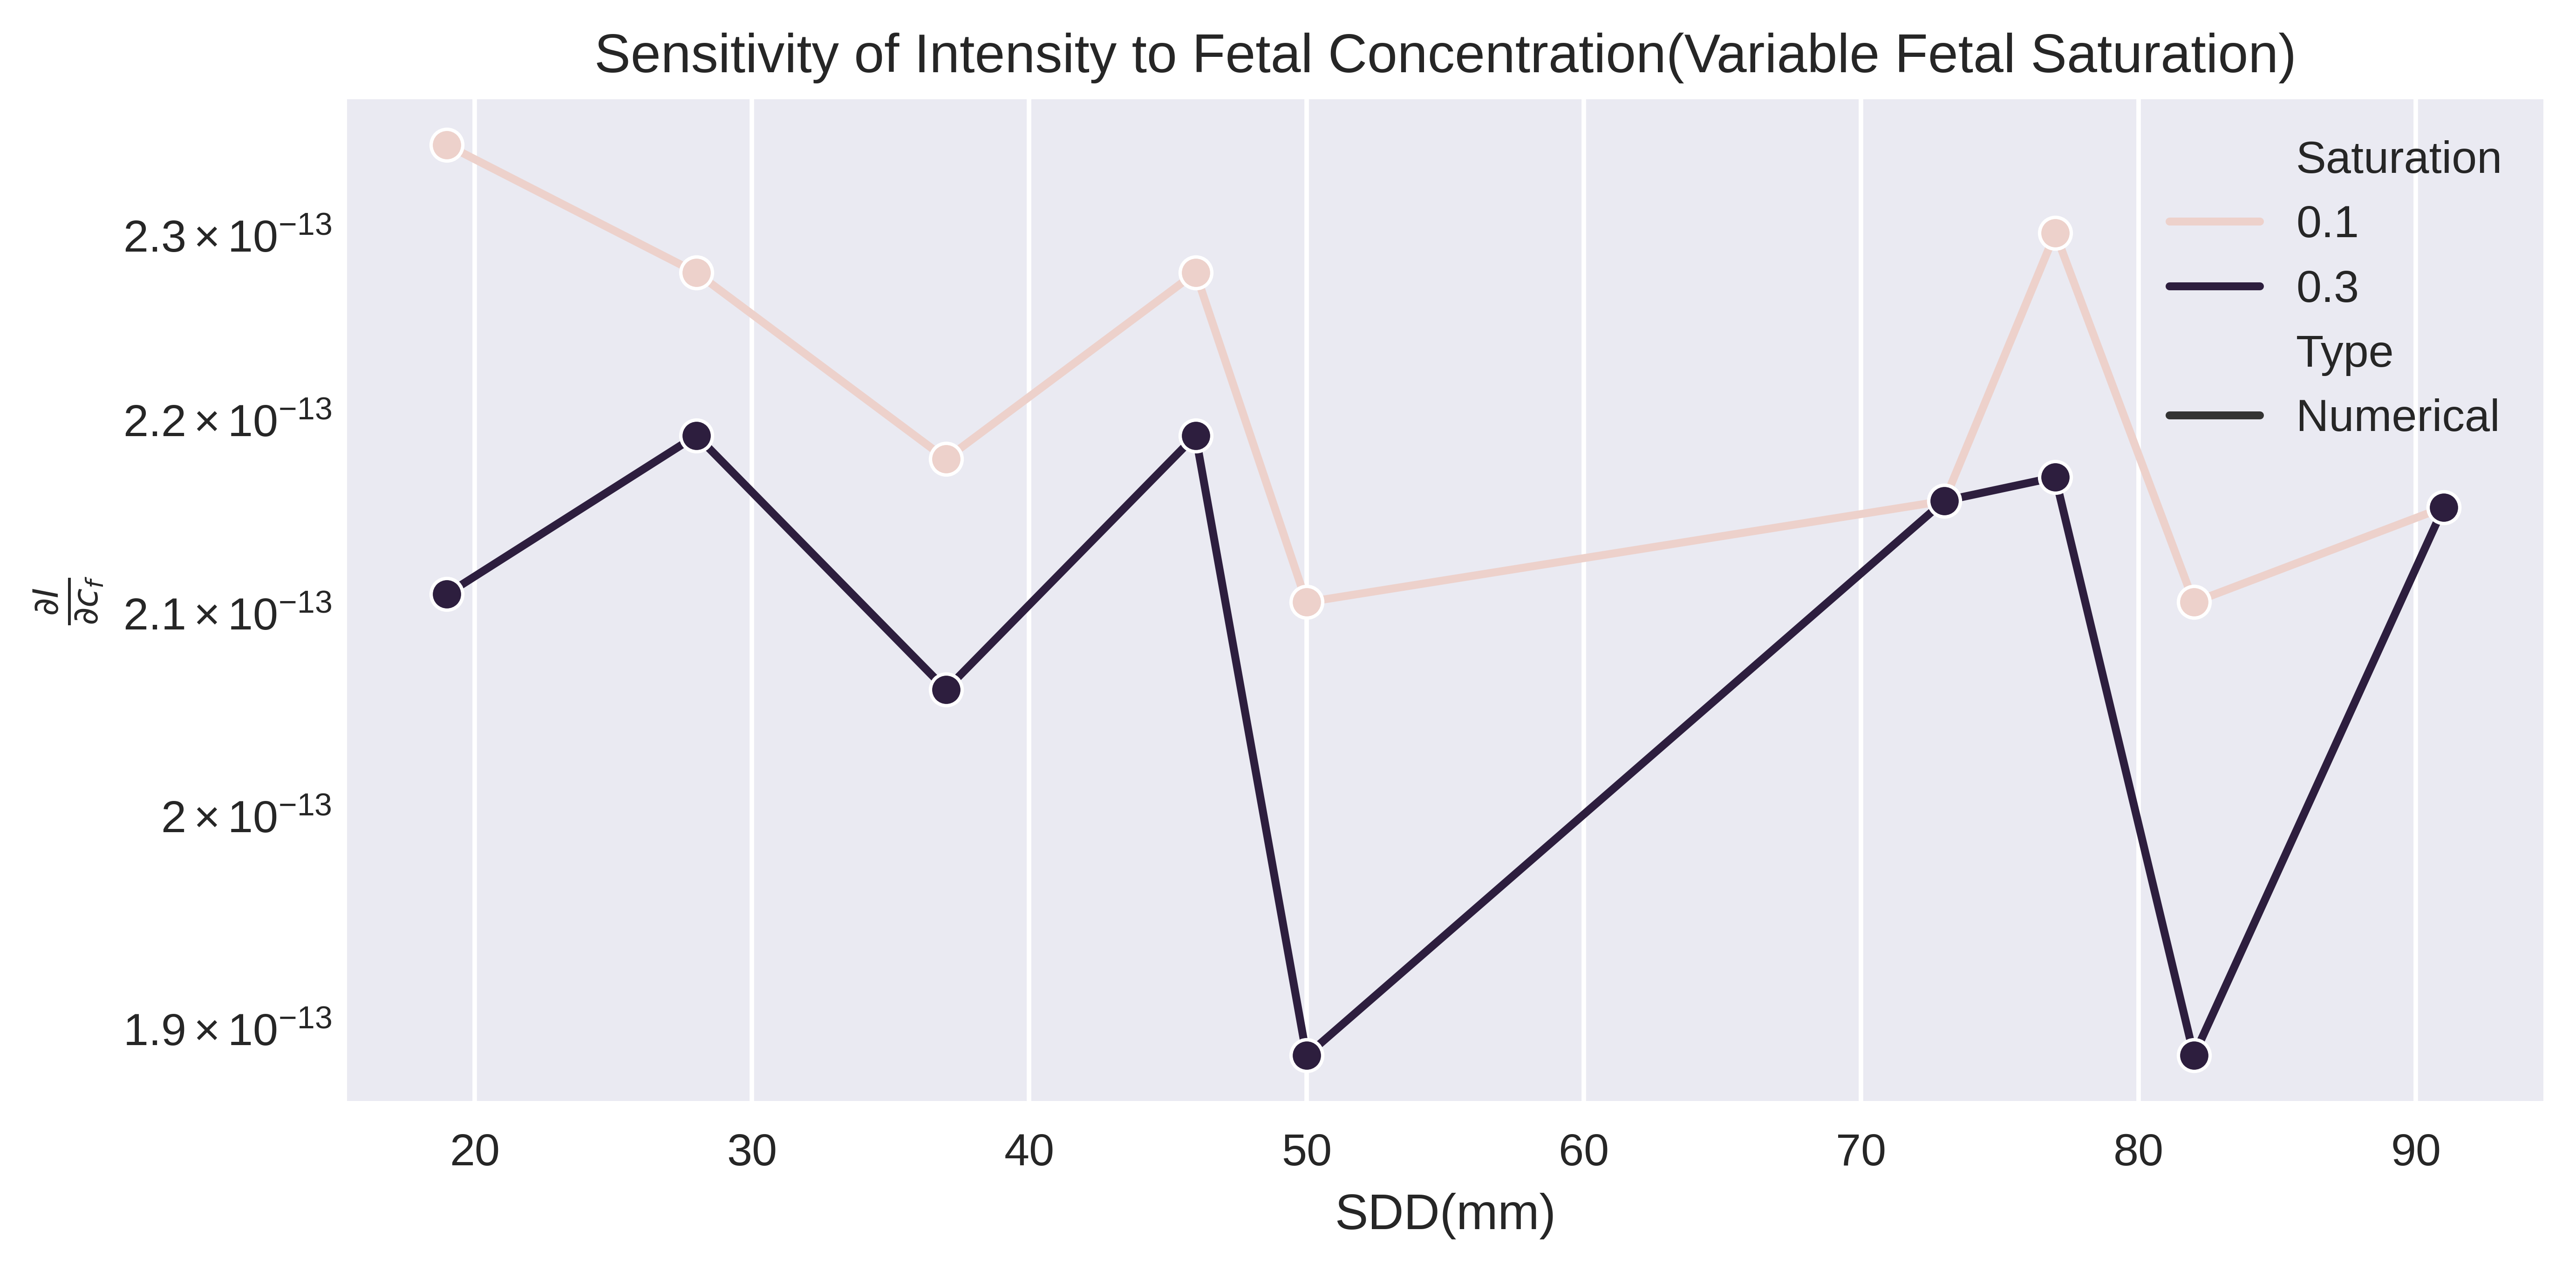

In [28]:
plt.figure(figsize=(8, 4))
data_table['Derivative'] = np.abs(data_table['Derivative'])
sns.lineplot(data=data_table, x='SDD', y='Derivative', hue='Saturation', style='Type', marker='o')
plt.title('Sensitivity of Intensity to Fetal Concentration(Variable Fetal Saturation)')
plt.legend()
plt.yscale('log')
plt.xlabel('SDD(mm)')
plt.ylabel(r'$\frac{\partial I}{\partial c_f} $')
plt.tight_layout()